In [1]:
sc.install_pypi_package("matplotlib")
sc.install_pypi_package("requests")
sc.install_pypi_package("sklearn")
sc.install_pypi_package("rouge")
sc.install_pypi_package("s3fs")
sc.install_pypi_package("boto3")
sc.install_pypi_package("networkx")
sc.install_pypi_package("boto3")


VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
21,application_1588697418736_0022,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package already installed for current Spark context!
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/context.py", line 1110, in install_pypi_package
    raise ValueError("Package already installed for current Spark context!")
ValueError: Package already installed for current Spark context!



In [2]:
sc.install_pypi_package("pyrouge")
sc.install_pypi_package("IPython")
sc.install_pypi_package("numpy")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Processing /mnt/var/lib/livy/.cache/pip/wheels/a4/5b/9a/2886f984445146fa94b3629de3ad6e5c1d4b931285716461bb/pyrouge-0.1.3-py3-none-any.whl

  Using cached ipython-7.14.0-py3-none-any.whl (782 kB)
  Using cached traitlets-4.3.3-py2.py3-none-any.whl (75 kB)
  Using cached pexpect-4.8.0-py2.py3-none-any.whl (59 kB)
  Using cached Pygments-2.6.1-py3-none-any.whl (914 kB)
  Using cached pickleshare-0.7.5-py2.py3-none-any.whl (6.9 kB)
Processing /mnt/var/lib/livy/.cache/pip/wheels/b4/cb/f1/d142b3bb45d488612cf3943d8a1db090eb95e6687045ba61d1/backcall-0.1.0-py3-none-any.whl
  Using cached prompt_toolkit-3.0.5-py3-none-any.whl (351 kB)
  Using cached jedi-0.17.0-py2.py3-none-any.whl (1.1 MB)
  Using cached ipython_genutils-0.2.0-py2.py3-none-any.whl (26 kB)
  Using cached ptyprocess-0.6.0-py2.py3-none-any.whl (39 kB)
  Using cached wcwidth-0.1.9-py2.py3-none-any.whl (19 kB)
  Using cached parso-0.7.0-py2.py3-none-any.whl (100 kB)


In [3]:
sc.install_pypi_package("pandas")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached pandas-1.0.3-cp36-cp36m-manylinux1_x86_64.whl (10.0 MB)

In [4]:
from IPython.display import display
from pylab import *
import numpy as np

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
import s3fs
import matplotlib.pyplot as plotting
import boto3
from pyspark.sql.functions import trim
from pyspark.sql.functions import regexp_replace, col
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from sklearn.feature_extraction.text import *
from nltk.tokenize.punkt import PunktSentenceTokenizer
import networkx as netx
import pandas
import nltk
import bs4 as BeautifulSoup
import urllib.request
import rouge
import requests
from rouge import Rouge 


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# lists that store the metrics after summeries are generated
my_metric_precision =[]
my_metric_recall =[]
my_metric_fstat = []

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# tokenizes each line passed 
def getTokensForEachSentence(sentence):
    line = ' '.join(sentence.strip().split('\n'))
    tokenizer_line = PunktSentenceTokenizer()
    new_lines = tokenizer_line.tokenize(line)
    return new_lines

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# converts a collection of text documents to vectors of token counts
def applyCountVectorizerForLine(sentence):
    countVector = CountVectorizer().fit_transform(sentence).toarray()
    return countVector

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
# generates the tf-idf value for each term which reflect the importance of a term to a document in the corpus
def getTFIDFScores(elements):
    normalizedMatrix = TfidfTransformer().fit_transform(elements)
    return (normalizedMatrix * normalizedMatrix.T)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
# Creates a new graph from an adjacency matrix and applies page rank algorthim to it
def getPageRankScores(elements):
    mySparseGraph = netx.from_scipy_sparse_matrix(elements)
    ranks = netx.pagerank(mySparseGraph)
    return ranks

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
from rouge import Rouge
# uses rouge and evaluates the performance of the summerization
def prepareScore(generateDF, abstractDF, n, outputDF):
    for aggregator in ['Average']:
        print('Analysis of the generated summary with reference summary using {}'.format(aggregator),"for the Model-", n)
        AvgScore = aggregator == 'Average'
        BestScore = aggregator == 'Best'

        rouge = Rouge()

        assume=[]
        for rowId, row in generateDF.iterrows():
            assume.append(row['generated'])

        ref=[]
        for rowId, row in abstractDF.iterrows():
            ref.append(row['summary'])

        outputs = rouge.get_scores(assume, ref, avg = True)

        for metricType in (outputs.items()):
            outputDF = outputDF.append({'Best/Average': 'Average', 'Metric':metricType[0], 'ModelNumber':n, 'Precision': 100 * metricType[1]['p'], 'F-stat': 100 * metricType[1]['f'],  'Recall': 100 * metricType[1]['r'] }, ignore_index=True)
            if metricType[0] == 'rouge-l' and aggregator == 'Average':
                my_metric_precision.append(100 *  metricType[1]['p'])
                my_metric_recall.append(100 *  metricType[1]['r'])
                my_metric_fstat.append(100 *  metricType[1]['f'])
    return outputDF

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
# read the input from s3 bucket
news = spark.read.format('csv').options(header='true', inferSchema='true', mode ="DROPMALFORMED").load('s3://bigdata-project-summary/news_summary.csv')
# drop the null values if any
news = news.dropna()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
news_subset = pandas.DataFrame(columns=['summary', 'text'])
news_pandas = news.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
# read the URL for each document and gets the respective data from the URL
for row in news_pandas.iterrows():
    url = row[1][3]
    text = row[1][4]
    try:
        request = requests.get(url)
        fetched_data = urllib.request.urlopen(url)
        article_read = fetched_data.read()
        article_parsed = BeautifulSoup.BeautifulSoup(article_read,'html.parser')
        paragraphs = article_parsed.find_all('p')
        article_content = ''
        for p in paragraphs:
            article_content += p.text
        news_subset = news_subset.append({'summary': text, 'text': article_content}, ignore_index=True)
    except:
        continue


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [50]:
display(news_subset)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                               summary                                               text
0    "The members of a Norwegian anti-immigrant gro...  Comments posted on Norwegian ‘Fatherland first...
1    Investigators have released pictures showing h...  Pilots mistook the taxiway at San Francisco In...
2    Two sunbathers, a 56-year-old man and an eight...  Portuguese media says 56-year-old man and eigh...
3    Abu Ismail, mastermind of the Amarnath Yatra a...   Jump to navigationSpeak NowSlain Lashkar-e-Ta...
4    "A self-styled email prankster, known as @SINO...  Man used emails to trick Anthony Scaramucci an...
..                                                 ...                                                ...
969  Reports of actress Ayesha Takia undergoing pla...   Jump to navigationSpeak NowPlastic surgery is...
970  With 'Jolly LLB 2' becoming actor Akshay Kumar...   Jump to navigationSpeak NowAkshay Kumar is on...
971  A new poster of the upcoming epic histori

In [36]:
# drop null values and extract 2 columns which we are going to work with
news = news_subset.dropna()
text = news['text']
reference = news['summary']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
# write the input dataframe containing the reference and generated summary to S3

inputDF = news.to_csv(None).encode()
s3 = boto3.resource('s3')
object = s3.Object('bigdata-project-summary', 'input.csv')
object.put(Body=inputDF)



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'ResponseMetadata': {'RequestId': '03E389D5D572950E', 'HostId': 'Jk6BXLDqKfXqgK3Rm7w+JyGmGdVox2CikZsGu/o1ne0gHdJctX2j8ycpFEd7l/60RHsyVYNx+qk=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'Jk6BXLDqKfXqgK3Rm7w+JyGmGdVox2CikZsGu/o1ne0gHdJctX2j8ycpFEd7l/60RHsyVYNx+qk=', 'x-amz-request-id': '03E389D5D572950E', 'date': 'Fri, 08 May 2020 20:38:18 GMT', 'etag': '"4d6b872afbc018e516be04662d0a7131"', 'content-length': '0', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'ETag': '"4d6b872afbc018e516be04662d0a7131"'}

In [38]:
frame = text.to_frame()
newsRDD = sc.parallelize(text).map(lambda x:(x,))
tokenDF = newsRDD.map(lambda sentence: getTokensForEachSentence(sentence[0]))
frame['sentence'] = tokenDF.collect()
cvDF = tokenDF.map(lambda token: applyCountVectorizerForLine(token))
frame['vectors'] = cvDF.collect()
graphDF = cvDF.map(lambda cv: getTFIDFScores(cv))
frame['tf_idf'] = graphDF.collect()
resultDF = graphDF.map(lambda graph: getPageRankScores(graph))
frame['scores'] = resultDF.collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
sentence_list = []
for rowId, eachRow in frame.iterrows():
    ordered = sorted(((eachRow['scores'][rowId],sent) for rowId,sent in enumerate(eachRow['sentence'])),reverse=True)
    eachSentence = ""
    for sentences in range(3):
        if sentences < len(ordered):
            eachSentence = eachSentence + ordered[sentences][1]
    sentence_list.append(eachSentence)
frame['generated'] = sentence_list

referenceDF = reference.to_frame()
generatedDF = frame['generated'].to_frame()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
# create a dataframe with the summary generated and given reference summary
comparisonDF = pandas.concat([referenceDF,generatedDF],axis =1)
display(comparisonDF)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                               summary                                          generated
0    "The members of a Norwegian anti-immigrant gro...  This should never happen,” “Islam is and alway...
1    Investigators have released pictures showing h...  The Air Canada pilots mistook the taxiway for ...
2    Two sunbathers, a 56-year-old man and an eight...  “It happened very fast, there was no chance to...
3    Abu Ismail, mastermind of the Amarnath Yatra a...  Ismail will be the new Kashmir division chief ...
4    "A self-styled email prankster, known as @SINO...  The Washington Post reported that Priebus was ...
..                                                 ...                                                ...
969  Reports of actress Ayesha Takia undergoing pla...  She also shot for a music video for Amit Mishr...
970  With 'Jolly LLB 2' becoming actor Akshay Kumar...  For reprint rights: Syndications TodayCopyrigh...
971  A new poster of the upcoming epic histori

In [41]:
# write the output dataframe containing the reference and generated summary to S3
writeDF = comparisonDF.to_csv(None).encode()
s3 = boto3.resource('s3')
object = s3.Object('bigdata-project-summary', 'output.csv')
object.put(Body=inputDF)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'ResponseMetadata': {'RequestId': '986451B164D4DAFA', 'HostId': 'AY0TAuW/HVME0QKrZ2aIzsgGRou2eOZwiLCnY0Sfs1L419+BaX7hq3joso5LfduFd+fgXlQ8McU=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'AY0TAuW/HVME0QKrZ2aIzsgGRou2eOZwiLCnY0Sfs1L419+BaX7hq3joso5LfduFd+fgXlQ8McU=', 'x-amz-request-id': '986451B164D4DAFA', 'date': 'Fri, 08 May 2020 20:39:57 GMT', 'etag': '"4d6b872afbc018e516be04662d0a7131"', 'content-length': '0', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'ETag': '"4d6b872afbc018e516be04662d0a7131"'}

In [42]:

analysis = pandas.DataFrame(columns = ['Best/Average', 'Metric', 'ModelNumber', 'Precision', 'F-stat', 'Recall'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
# computing the performace metrics
for num in range(1,11,2):
    outputDF = pandas.DataFrame(columns = ['Best/Average', 'Metric', 'ModelNumber', 'Precision', 'F-stat', 'Recall'])
    sentence_list = []
    for rowId, eachRow in frame.iterrows():
        ordered = sorted(((eachRow['scores'][rowId],sent) for rowId,sent in enumerate(eachRow['sentence'])),reverse=True)
        eachSentence = ""
        for sentences in range(num):
            if sentences < len(ordered):
                eachSentence = eachSentence + ordered[sentences][1]
        sentence_list.append(eachSentence)
    frame['generated'] = sentence_list
    referenceDF = reference.to_frame()
    outputDF = prepareScore(frame, referenceDF, num, outputDF)
    analysis = analysis.append(outputDF)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Analysis of the generated summary with reference summary using Average for the Model- 1
Analysis of the generated summary with reference summary using Average for the Model- 3
Analysis of the generated summary with reference summary using Average for the Model- 5
Analysis of the generated summary with reference summary using Average for the Model- 7
Analysis of the generated summary with reference summary using Average for the Model- 9

In [45]:
display(analysis)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Best/Average   Metric ModelNumber  Precision     F-stat     Recall
0      Average  rouge-1           1  19.850909  21.024375  26.888943
1      Average  rouge-2           1   6.930425   7.593070  10.110830
2      Average  rouge-l           1  17.625030  18.711165  22.930884
0      Average  rouge-1           3  16.733237  24.006047  48.816843
1      Average  rouge-2           3   6.727487   9.848899  21.001363
2      Average  rouge-l           3  16.768692  23.352275  42.198959
0      Average  rouge-1           5  14.298892  22.714083  60.603814
1      Average  rouge-2           5   6.591465  10.567803  29.006910
2      Average  rouge-l           5  15.387135  23.524340  53.302826
0      Average  rouge-1           7  12.782078  21.197298  66.584444
1      Average  rouge-2           7   6.262446  10.425392  33.227372
2      Average  rouge-l           7  14.202715  22.682705  59.132627
0      Average  rouge-1           9  11.744734  19.862449  68.553588
1      Average  rouge-2           

In [51]:
print(my_metric_precision)
print(my_metric_recall)
print(my_metric_fstat)
Number_sentences = [1,3,5,7,9]


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[17.625029766657715, 16.768691729464265, 15.387134788231505, 14.20271475438661, 13.201248751799794, 17.625029766657715, 16.768691729464265, 15.387134788231505, 14.20271475438661, 13.201248751799794]
[22.93088425870308, 42.198959351164476, 53.302826268378155, 59.13262709438262, 61.111572428838954, 22.93088425870308, 42.198959351164476, 53.302826268378155, 59.13262709438262, 61.111572428838954]
[18.711165043902643, 23.352274886241496, 23.524339549559027, 22.682704571481665, 21.549040431177858, 18.711165043902643, 23.352274886241496, 23.524339549559027, 22.682704571481665, 21.549040431177858]

In [52]:
writeDF = analysis.to_csv(None).encode()
s3 = boto3.resource('s3')
object = s3.Object('bigdata-project-summary', 'analysis.csv')
object.put(Body=inputDF)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'ResponseMetadata': {'RequestId': '12287F261B5DA5C7', 'HostId': '3sSNW2IXkzo/LO6ZXuuf1BSyjipEQTTQtKItPeObohjjIJuQlHoan/fH2wKo/H7iP9K55RDtj6I=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': '3sSNW2IXkzo/LO6ZXuuf1BSyjipEQTTQtKItPeObohjjIJuQlHoan/fH2wKo/H7iP9K55RDtj6I=', 'x-amz-request-id': '12287F261B5DA5C7', 'date': 'Fri, 08 May 2020 20:42:25 GMT', 'etag': '"4d6b872afbc018e516be04662d0a7131"', 'content-length': '0', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'ETag': '"4d6b872afbc018e516be04662d0a7131"'}

<BarContainer object of 5 artists>

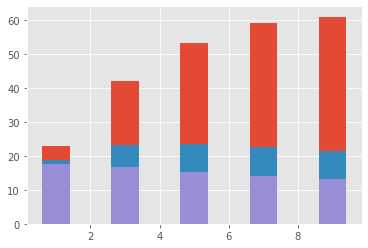

In [53]:
%%local
%matplotlib inline
import matplotlib.pyplot as plotting
plotting.style.use('ggplot')
fig, axs = plotting.subplots()
axs.bar(Number_sentences,my_metric_recall,label = "Recall")
axs.bar(Number_sentences,my_metric_fstat,label = "Fstatistics")
axs.bar(Number_sentences,my_metric_precision,label = "Precision")


Text(0.5, 0, 'Number of sentences Increases along X-axis')

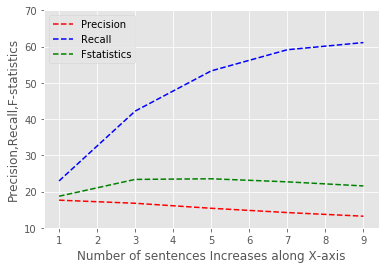

In [54]:
%%local
%matplotlib inline
import matplotlib.pyplot as plotting
plotting.style.use('ggplot')
plotting.figure()
plotting.plot(Number_sentences, my_metric_precision, 'r--', label ='Precision')
plotting.plot(Number_sentences, my_metric_recall, 'b--', label ='Recall')
plotting.plot(Number_sentences, my_metric_fstat, 'g--', label ='Fstatistics')
axes = plotting.gca()
axes.set_ylim([10,70])
plotting.legend()
plotting.ylabel('Precision,Recall,F-statistics')
plotting.xlabel('Number of sentences Increases along X-axis')

Text(0.5, 0, 'Number of sentences Increases along X-axis')

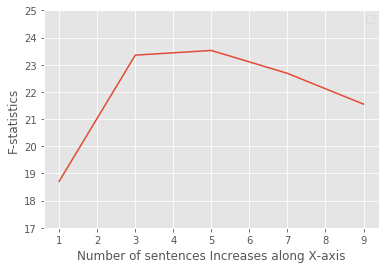

In [55]:
%%local
%matplotlib inline
import matplotlib.pyplot as plotting
plotting.style.use('ggplot')
plotting.figure()
plotting.plot(Number_sentences, my_metric_fstat)
axes = plotting.gca()
axes.set_ylim([17,25])
plotting.legend()
plotting.ylabel('F-statistics')
plotting.xlabel('Number of sentences Increases along X-axis')